# ASTR 21100 

# "Computational Techniques in Astrophysics"

## Instructor: Andrey Kravtsov

### office: ERC 415; email: kravtsov@uchicago.edu
### office hours: Tue, 10:30am-noon (unless noted otherwise)

#### Teaching Assistants: 
#### Dimitrios Tanoglidis (dtanoglidis@uchicaago.edu)
#### Georgios Zakharegkas (gzakharegkas@uchicago.edu)

### Histograms and methods for choosing bin width, Kernel Density Estimate (KDE) method

In [11]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline
# reusing my codes from the repository
from codes.plot_utils import plot_pretty
plot_pretty(dpi=150, fontsize=12)

Here is, for example, a very influential histogram of globular cluster metallicities from a paper by William Harris - astronomer who constructed and maintains the catalog of Milky Way's globular clusters that we've used to examine their metallicity distribution (<a href="http://ned.ipac.caltech.edu/level5/Harris2/Harris1.html">Harris W. 1999, “Globular cluster systems: formation models and case studies”</a>). It's an older paper, so he uses older globular cluster catalog that contained fewer clusters, but he uses $N_{\rm bins} = 26$, which is close to the most common choice you made. 

<img width=400 src="http://ned.ipac.caltech.edu/level5/Harris2/Figures/figure3.gif"></img>

### Is "looks good" approach always good enough?

For quick everyday explorations and plots the "looks good" approach is fine. However, when we suspect interesting features in the data or prepare a plot for a presentation or publication we may need to be more careful and use a more objective method. 

Actually, it is possible to pass option <tt>bins='auto'</tt> to the  <a href="https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html"><tt>hist</tt></a> routine of <tt>matplotlib.pyplot</tt> library. 

That routine simply uses <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html">numpy.histogram</a> routine and so can accept the options that this numpy routine takes. 
Among possible choices for <tt>bins</tt> in this routine are  <tt>'auto', 'sturges', 'fd', 'doane', 'scott', 'rice', 'sqrt'.</tt> What are all these options? 

### Heuristic rules for estimating number of bins or bin width

These options refer to different  <a href="https://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width">"heuristic rules"</a> for estimating the optimal number of bins or, equivalently, the bin width.  

These rules rely on some assumption about shape of the underlying function (i.e., that it is unimodal and symmetric) or are designed to minimize effect of outliers in the data samples on the reconstructed function.

For example, <tt>'sturges'</tt> refers to the <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/wics.35">"Sturges rule"</a> that posits that for a sample vector of values $\mathbf{x}$ of size $N$ the number of histogram bins should be $N_{b, \rm Sturges}=\lceil\log_2 N\rceil+1$, where $\lceil\ldots\rceil$ indicates <a href="https://en.wikipedia.org/wiki/Floor_and_ceiling_functions#The_ceiling_function">"ceiling" function</a> (nearest largest integer value). 

<tt>'fd'</tt> refers to the <a href="https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule">"Freedman-Diaconis rule"</a> that posits that the bin width should be
$$h_{\rm FD}=2\,\frac{{\rm IQR(\mathbf{x})}}{N^{1/3}},$$
where function ${\rm IQR}(\mathbf{x})$ is the *interquartile range* of sample values in the vector $\mathbf{x}$. If we sort the samples in the increasing order of their $x$ value and $x_{25}$ and $x_{75}$ are values of $x$ for which 25% of the sample are smaller than $x_{25}$ and 25% of the samples are larger than $x_{75}$, then ${\rm IQR}(\mathbf{x})=x_{75}-x_{25}$. 

Heuristic arguments can be used to show that for most distribution the optimal number of bins scales as 

$$N_{\rm b}=\alpha N^{1/3},$$

where $\alpha$ depends on the distribution. This is why $N^{1/3}$ appears in many of the heuristic rules. 

### Heuristic rules for the number of bins or bin width
for a vector of sample values $\mathbf{x}$ of size $N$ the number of histogram bins of equal width is related to the bin width as: 

$$N_{\rm b} = \left\lceil \frac{{\rm max}(\mathbf{x}) - {\rm min}(\mathbf{x})}{h}\right\rceil, $$

| rule name |  Number of bins or bin width | Comments |
|------|------------------------------|-----------|
| Sturges | $$N_{b, \rm Sturges}=\lceil\log_2 N\rceil+1$$ | assumes Gaussian distribution and heuristic (generally incorrect) about number of bins, only gives reasonable result for $N<200$ |
| Rice | $$N_{b, \rm Rice}=\lceil 2N^{1/3}\rceil$$ | tries to remedy slow increase of the number of bins of the Sturges rule |
| Square root | $$N_{b, \rm sqrt}=\lceil \sqrt{N}\rceil$$ | tries to remedy slow increase of the number of bins of the Sturges and Rice rules, used in Excel spreadsheets as a default |
| Scott | $$h_{\rm Scott} = \frac{3.5\sigma}{N^{1/3}}$$ | $\sigma$ is rms of the sample distribution, assumes Gaussian distribution | 
| Freedman-Diaconis | $$h_{\rm FD}=2\,\frac{{\rm IQR(\mathbf{x})}}{N^{1/3}},$$ | replaces $3.5\sigma$ of the Scott rule with $2\,{\rm IQR(\mathbf{x})}$ to avoid sensitivity of $\sigma$ to outliers | 


In [12]:
ZGCs = np.loadtxt('data/gcz.dat', usecols=(1), unpack=True)

ngc = np.size(ZGCs)

n13 = np.power(ngc, 1./3.)
print("the number of bins using Sturges rule is %d"%(np.ceil(np.log2(ngc)+1)))
print("the number of bins using Rice rule is %d"%(np.ceil(2.*n13)))
print("the number of bins using sqrt rule is %d"%(np.ceil(np.sqrt(ngc))))
# Scott rule; sigma is computed using np.std (standard deviation) routine
hscott = 3.5 * np.std(ZGCs) / n13
nscott = np.ceil((ZGCs.max()-ZGCs.min()) / hscott)
print("the number of bins using Scott rule is %d"%(nscott))

hfd = 2. * (np.percentile(ZGCs,75) - np.percentile(ZGCs,25))/ngc**(1./3)
nfd = (ZGCs.max()-ZGCs.min())/hfd
print("the number of bins using Freedman-Diaconis rule is %d"%(np.ceil(np.log2(ngc)+1)))


the number of bins using Sturges rule is 9
the number of bins using Rice rule is 11
the number of bins using sqrt rule is 13
the number of bins using Scott rule is 7
the number of bins using Freedman-Diaconis rule is 9


The number of bins predicted by these rules varies by almost a factor of 2 for this case, but all numbers are twice or more smaller than "looks good" result we produce using our aesthetic gut feeling. 

### Something a bit more objective? The Shimazaki-Shinomoto method

Developed by <a href="http://www.neuralengine.org/res/pdf/shimazaki_neco07.pdf">Shimazaki & Shinomoto (2007)</a> to bin discrete counts of some signal as a function of time, assuming that noise in accumulated counts is described by the <a href="https://en.wikipedia.org/wiki/Poisson_distribution">Poisson distribution</a>. Can be applied to general binning problem of samples in a vector $\mathbf{x}$, if this assumption is reasonable.  

The method defines  a grid of bin numbers $\{N\}=N_{\rm min}\ldots, N_{\rm max}$, which encompass all expected reasonable numbers for bits, and for each number of bins $N$ and corresponding bin width $h=(x_{\rm max}-x_{\rm min})/N$ computes the following ***cost function***:

$$C(h) = \frac{2\bar{n}-v}{h^2}, $$

where $\bar{n}$ and $v$ are the mean and the biased variance of the sample counts in the bins: 

$$\bar{n}=\frac{1}{N}\,\sum\limits_{i=0}^{N-1}n_i,$$
$$ v=\frac{1}{N}\,\sum\limits_{i=0}^{N-1}(n_i-\bar{n})^2,$$

***The number of bins that minimizes $C(h)$ is the optimal number.*** 

One of the key characteristics of the Poisson distribution is that its mean $\mu$ is equal to its variance $\sigma^2=\mu$. Or, in other words, the standard deviation of the Poisson distribution is $\sigma = \sqrt{\mu}$. 

Thus, for if sample counts in bins have the Poisson distribution, we should have $2\bar{n}-v\approx \bar{n}\approx v=\sigma^2$. Thus the minimized cost function is 

$$C(h) = \frac{2\bar{n}-v}{h^2}\approx \left(\frac{\sigma}{h}\right)^2$$

As the bin width decreases with increasing number of bins, the number of samples per bin decreases and their scatter $\sigma$ increases. Thus, minimizing $C(h)$ finds an *optimal* bin width that is a tradeoff between desire to have small bin size, while keeping the "Poisson noise" due to limited number of bins in check. 

In [13]:
def shimazaki_shinomoto_rule(x, Nbmin=4, Nbmax=500):
    """
    Compute the number of bins for samples in a vector x using the 
    Shimazaki and Shinomoto (2007) method
    """
    x_max = np.max(x)
    x_min = np.min(x)
    Nbins = np.arange(Nbmin, Nbmax) # vector of bin numbers
    hb = (x_max - x_min) / Nbins    # bin size vector
    C = np.empty_like(hb)

    # computation of the cost function
    for i, Nb in enumerate(Nbins): 
        ni = np.histogram(x, bins=Nb)[0]
        nbar = np.mean(ni) # mean of counts in bins
        v = np.var(ni)  # biased variance estimate of counts in bins
        C[i] = (2. * nbar - v) / (hb[i]**2) # the cost function 

    # optimal bin size: find index of the smallest C
    imin = np.argmin(C)
    Nb_best, h_best  = Nbins[imin], hb[imin]
    return Nb_best, h_best     

In [14]:
nss, hss = shimazaki_shinomoto_rule(ZGCs, Nbmin=4, Nbmax=500)

print("number of bins according to Shimazaki-Shinomoto method is %d"%nss)

number of bins according to Shimazaki-Shinomoto method is 6


### The Knuth method

A  rigorous Bayesian statistics estimate of the optimal number of bins was proposed by physicist <a href="http://knuthlab.rit.albany.edu/">Kevin Knuth</a> in 2006. Detailed justification of the method can be found in his <a href="http://adsabs.harvard.edu/abs/2006physics...5197K">paper</a>) and is beyond the scope of this lecture. 

We can use it, however, to see what it gives in this case. 

The method considers histogram as a piecewise constant model of the data and computes the Bayesian likelihood for such model given the data with a simple, non-informative prior to compute the posterior distribution for the bin size. 

In [15]:
from codes.histtools import knuth_bin_width

h_knuth, bins_knuth = knuth_bin_width(ZGCs, return_bins=True)

n_knuth = np.shape(bins_knuth)[0] - 1
print("number of bins according to Knuth method is %d"%nss)

Optimization terminated successfully.
         Current function value: -1.763100
         Iterations: 15
         Function evaluations: 42
number of bins according to Knuth method is 6


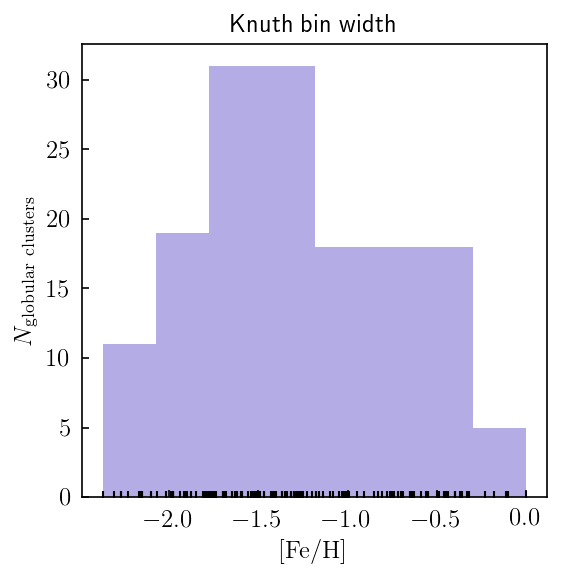

In [16]:
from codes.plot_utils import plot_histogram 
plot_pretty(dpi=150, fontsize=12)

plot_histogram(ZGCs, bins=bins_knuth, xlabel=r'$\rm [Fe/H]$', ylabel=r'$N_{\rm globular\ clusters}$', 
               tickmarks=True, plot_title='Knuth bin width', figsize=4.0)

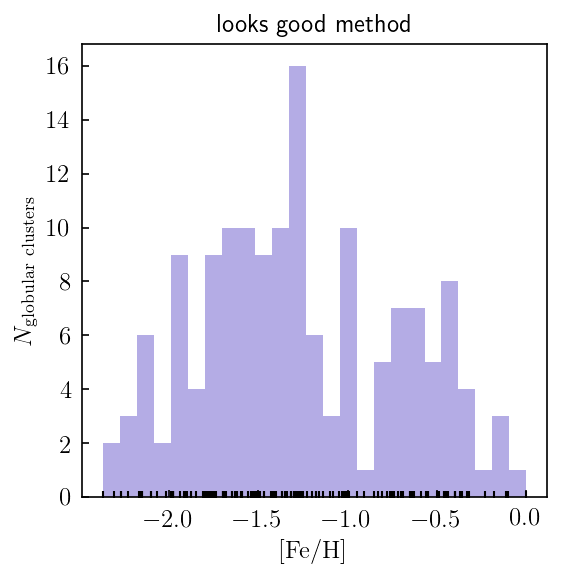

In [17]:
plot_histogram(ZGCs, bins=25, xlabel=r'$[\rm Fe/H]$', ylabel=r'$N_{\rm globular\ clusters}$', 
               tickmarks=True, plot_title='looks good method', figsize=4.0)

### Adaptive bin sizes 

Objective methods for producing histograms with variable bin size are also used, in particular the <a href="http://jakevdp.github.io/blog/2012/09/12/dynamic-programming-in-python/">***Bayesian blocks*** method</a> proposed by astronomer Jeff Scargle and collaborators in 2012 (<a href="https://ui.adsabs.harvard.edu/abs/2013ApJ...764..167S/abstract">Scargle et al. 2013</a>) for binning counts in astronomical time series, in which there are lull periods when nothing happens and large bin sizes can be used and sudden bursts of flux, as during gamma-ray bursts, when bin sizes need to be adaptively decreased to capture structure of the signal.   

It uses approach similar to that of the Knuth method, but relaxes assumption of the constant bin size. 

For the case of globular cluster metallicities that we have considered it produces results similar to that of the Knuth's method. 

### Conclusions and guidelines

* When it matters: i.e. when histogram shows structure in the data that may or may not be real, predictions of several objective methods should be tried for the bin size. 


* Knuth and Shinazaki-Shinomoto methods are a good choice. For functions that exhibit rapid changes on different scales, adaptive bin size of the Bayesian blocks method of Scargle et al. (2013) should be considered as an alternative. 


* Only when structure is apparent for the bin widths predicted by these methods should be considered to be real. 


* Further proof that structure is real requires building a model and performing statistical model testing and comparison that is often non-trivial. 

### Histograms and Kernel density estimates (KDE)

Histograms are a specific example of the kernel density estimate (KDE) of discrete samples

$$\hat{\rho}(x)=\frac{1}{Nh}\sum\limits_{i=0}^{N-1}K\left(\frac{x-x_i}{h}\right),$$

which use "tophat" function for the kernel $K$:

$$
K_{\rm TH}(x-x_i,h) = \frac{1}{2}
    \begin{cases}
            1, &         \mathrm{if\ } -h/2<x-x_i\leq h/2,\\
            0, &         \mathrm{otherwise\ },
    \end{cases}
$$

where $h$ is bin size, $x_i$ are locations of the sample and $x$ is the bin center. 

In [18]:
from scipy.special import gamma

def k_TH(xi, dim=1):
    """
    multi-D tophat kernel
    """
    k_TH = np.zeros_like(xi)
    isel = (np.abs(xi) <= 0.5) 
    k_TH[isel] = 0.5 * gamma(0.5*dim) * dim / np.pi**(0.5*dim)
    return k_TH

def k_E(xi):
    """
    1d Epanechnikov kernel
    """
    k_E = np.zeros_like(xi)
    isel = (np.abs(xi) <= 1.) 
    k_E[isel] = 0.75 * (1.0 - xi[isel]*xi[isel])
    return k_E

def k_G(xi, dim=1):
    """
    multi-D Gaussian kernel; works for any D
    
    Parameters:
    -----------
        xi: numpy float array
        dim: integer
            number of dimension
    Returns:
    --------
        numpy array of Gaussian kernel values for each xi 
    """
    return np.exp(-0.5*xi*xi)/np.sqrt((2.*np.pi)**dim)

def distance(x1, xmany, dim=1):
    """
    compute vector of Eucledian distances between one point with coordinates x1
    and a vector of points with coordinates in array xmany in dim-dimensional space
    
    Parameters:
    -----------
    x1: numpy float array; shape(x1) = [dim]
        coordinates of a single point
    xmany: numpy floar array; shape(xmany) = [Nmany,dim]
        vector of coordinates of Nmany points
    """
    return np.sqrt(np.sum((x1[i] - xmany[:,i])**2 for i in range(dim)))

In [19]:
def kde(Xdata, Xgrid, dim=1, h=1., kernel='Epanechnikov'):
    """
    estimate KDE density for a sample of points Xdata on Xgrid points
    
    Parameters:
    -----------
    Xgrid: numpy array of floats with dimensions [ngrid, dim] in 1d 
           or [ngrid x ngrid, dim] in 2d
           of points at which to estimate density
           
    Xdata: numpy array of floats with dimensions [ndata, dim] 
           that contains data samples with number of properties equal to dim
           
    dim:   integer
           number of dimensions
        
    Returns:
    --------
    Z: numpy array of densities with dimensions [ngrid x ngrid, ndim]
    """
    # check input number of dimensions
    if not float(dim).is_integer(): 
        print("** Error KDE_density: input dim, must be integer, instead it is:", dim)
        exit(1)
    
    dim = int(dim) # just in case a float like 2. was passed
    
    if kernel == 'tophat':
        Z = np.zeros((np.shape(Xgrid)[0]))
        
        for i, Xdi in enumerate(Xdata):
            Z += k_TH(distance(Xdi, Xgrid, dim)/h, dim=dim) 
                       
        Z /= (0.5*np.shape(Xdata)[0]*h**dim)
        
    elif kernel == 'Gaussian':
        Z = np.sum(k_G(distance(Xdi, Xgrid, dim)/h, dim=dim) \
                    for Xdi in Xdata) / (np.shape(Xdata)[0]*h**dim)
     
    elif kernel == 'Epanechnikov':
        if dim == 1:
            Z = np.sum(k_E((Xi - Xgrid[:])/h) for Xi in Xdata) /\
                (np.shape(Xdata)[0]*h)
        elif dim == 2: 
            Z = np.sum(k_E((Xi[0] - Xgrid[:,0])/h)*k_E((Xi[1]-Xgrid[:,1])/h) for Xi in Xdata) /\
                (np.shape(Xdata)[0]*h**2)
        else: 
            print("Epanechnikov KDE is implemented only for D=1 or 2 dimensions, instead dim=%d"%d)
            exit(1) 
    else:
        raise Exception("**error: kde: specified kernel is not implemented!")
        
    return Z

In [42]:
nb = 10
Zmin, Zmax = 0.99*ZGCs.min(), ZGCs.max() + 0.001
h = (Zmax - Zmin)/(nb)

nh, Zbins = np.histogram(ZGCs, bins=nb)
Zgrid = 0.5 * (Zbins[1:] + Zbins[:-1])

Zgrid = Zgrid.reshape((np.size(Zgrid),1))
ZGC = ZGCs.reshape((np.size(ZGCs),1))

rho_kde = kde(ZGC, Zgrid, dim=1, h=h, kernel='tophat')

C:\Users\h2_sf\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


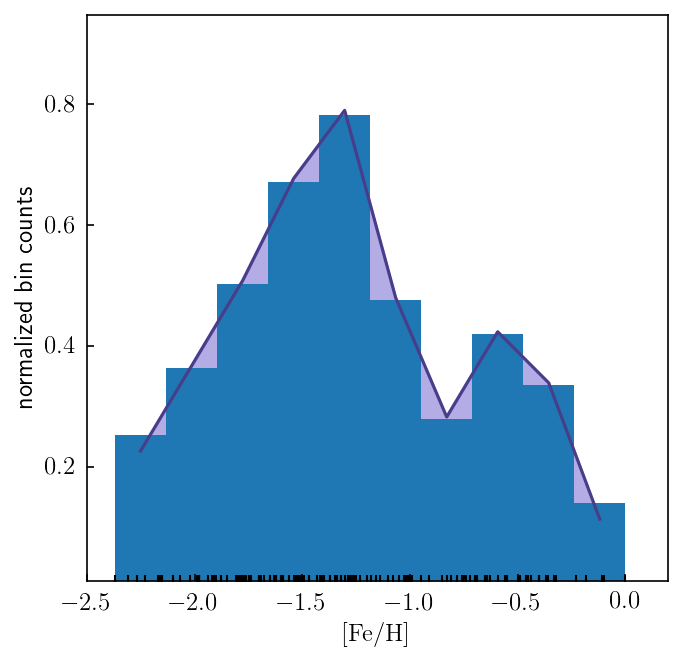

In [43]:
xlim = [-2.5,0.2]; ylim = [1.e-2,1.2*rho_kde.max()]
fig = plt.figure(figsize=(5, 5))
plt.xlim(xlim); plt.ylim(ylim)
#plt.yscale('log')
plt.xlabel(r'$\rm [Fe/H]$')
plt.ylabel(r'normalized bin counts')

# plot smoothed density estimate with Epanechnikov kernel as a shaded region
plt.fill_between(Zgrid.ravel(), rho_kde.ravel(), color='slateblue', alpha=0.5)
# plot histogram (KDE with tophat kernel) for comparison
plt.plot(Zgrid.ravel(), rho_kde.ravel(), color='darkslateblue', alpha=1.)
plt.hist(ZGCs, bins=nb, density=True)
# plot the actual z values of galaxies as little vertical tick marks
plt.plot(ZGCs, np.full_like(ZGCs, 1.01*ylim[0]), '|k', markeredgewidth=1)

plt.show()

### KDE with other kernel functions

We, of course, not limited to the tophat kernel. Recall, for example, that in the linear interpolation considered above each sample contributes to two neighboring grid cells centers. If the distance between grid cells is $h$ (bin width), the sample contributes weights 

$$w_{\rm left} = 1 - \frac{x-x_{\rm left}}{h};\ \ \ w_{\rm right}= \frac{x-x_{\rm left}}{h}.$$

This corresponds to the kernel $K(\xi)$ that has a triangular form centered at $\xi=0$ and non-zero only for $-0.5\leq \xi\leq 0.5$. 

In [82]:
# constructing histogram of [Fe/H] of globular clusters using linear interpolation (triangular kernel)
Zkde = np.zeros_like(Zgrid)

for i, Zd in enumerate(ZGCs):
    ibin = int((Zd-Zmin)/h)
    wright = (Zd-Zgrid[ibin]) / h 
    wleft = 1. - wright 
    Zkde[ibin] += wleft 
    if ibin+1 < nb:
        Zkde[ibin+1] += wright
        
Zkde = Zkde / (np.size(ZGCs) * h)

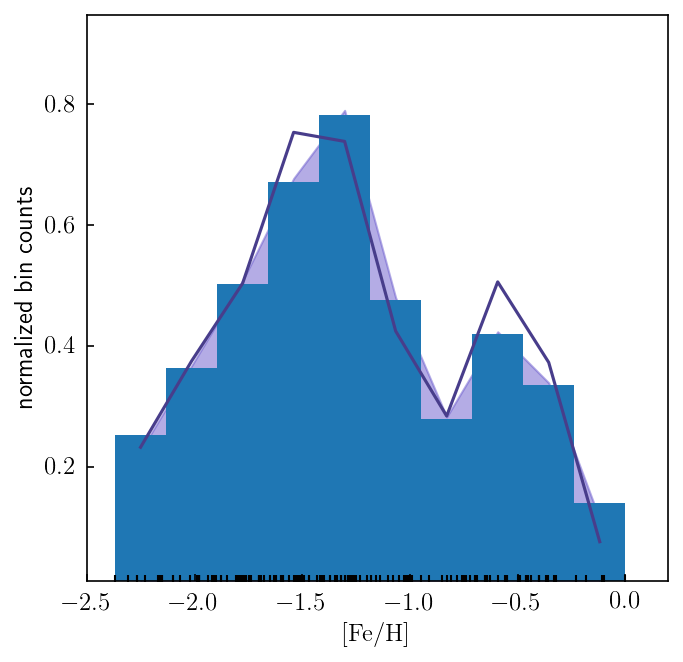

In [81]:
xlim = [-2.5,0.2]; ylim = [1.e-2,1.2*rho_kde.max()]
fig = plt.figure(figsize=(5, 5))
plt.xlim(xlim); plt.ylim(ylim)
#plt.yscale('log')
plt.xlabel(r'$\rm [Fe/H]$')
plt.ylabel(r'normalized bin counts')

# plot smoothed density estimate with Epanechnikov kernel as a shaded region
plt.fill_between(Zgrid.ravel(), rho_kde.ravel(), color='slateblue', alpha=0.5)
# plot histogram (KDE with tophat kernel) for comparison
plt.plot(Zgrid.ravel(), Zkde, color='darkslateblue', alpha=1.)
plt.hist(ZGCs, bins=nb, density=True)
# plot the actual z values of galaxies as little vertical tick marks
plt.plot(ZGCs, np.full_like(ZGCs, 1.01*ylim[0]), '|k', markeredgewidth=1)

plt.show()

More generally, for a set of $N$ data values $\{x_i\}$, KDE approximates density of measurements at point $x$ as 
$$\hat{\rho}(x)=\frac{1}{Nh}\sum\limits_{i=0}^{N-1}K\left(\frac{x-x_i}{h}\right),$$
where $K$ is a kernel function that is to be chosen and $h$ is the *kernel width*.


In [12]:
from sklearn.neighbors import KernelDensity

def plot_kernels():
    """Visualize the KDE kernels available in Scikit-learn"""
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.grid(color='white', linestyle='-', linewidth=2)

    X_src = np.zeros((1, 1))
    x_grid = np.linspace(-3, 3, 1000)

    for kernel in ['gaussian', 'tophat', 'epanechnikov',
                   'exponential', 'linear', 'cosine']:
        log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(x_grid[:, None])
        ax.plot(x_grid, np.exp(log_dens), lw=2, alpha=0.75, label=kernel)
    ax.set_ylim(0, 1.05); ax.set_xlim(-2.9, 2.9)
    ax.set_xlabel(r'$\xi$'); ax.set_ylabel(r'$K(\xi)$')
    ax.legend(loc=(1.05,0.5), frameon=False)
    plt.grid(ls='dotted', lw=0.5, color='gray')
    plt.show()

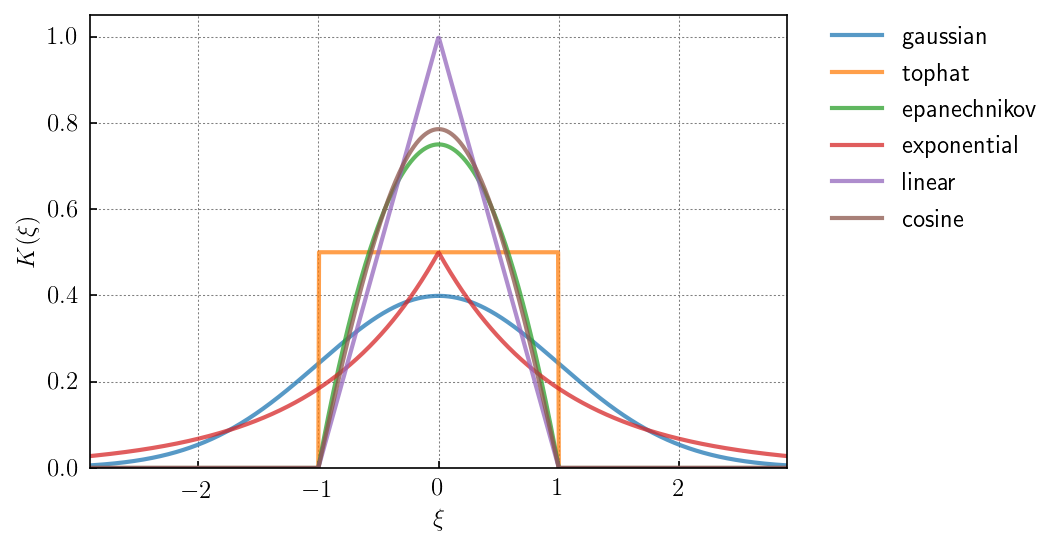

In [13]:
plot_kernels()

### Epanechnikov kernel

The Epanechnikov kernel minimizes variance and bias of the density estimate for a given width $h$ (<a href="http://epubs.siam.org/doi/10.1137/1114019">Epanechnikov 1969</a>): 

$$
K_E(x-x_i,h) = \frac{3}{4}\left[1-\left(\frac{x-x_i}{h}\right)^2\right]
$$

It has what is in the filter jargon called *"compact support"* (it does not extend beyond $h$). This is usually desirable because it limits the range of neighbor searches, which allows for efficient execution. However, it does not have a continuous first derivative, which may be an issue in some applications. 

<a href="https://mathisonian.github.io/kde/">Cool visual demonstration</a> of how KDE works in 1D. 

### KDE in $D$-dimensions

For a set of $N$ data values $\{\vec{x}_i\}$ in $D$ dimensions, KDE approximates density of measurements at point $x$ as 
$$\hat{\rho}(\vec{x})=\frac{1}{Nh^D}\sum\limits_{i=0}^{N-1}K\left(\frac{d[\vec{x},\vec{x}_i]}{h}\right),$$
where, as before, $K$ is *properly normalized* kernel function that is to be chosen, $h$ is the *kernel width*, and $d[\vec{x},\vec{x}_i]$ is distance between points $\vec{x}$ and $\vec{x}_i$ defined in some way.

For example, tophat kernel ("nearest grid") can be defined as:


$$
K_{\rm TH}(\xi) = 
    \begin{cases}
            1/V_{\rm D}(1), &         \mathrm{if\ } -1/2<\xi\leq 1/2,\\
            0, &         \mathrm{otherwise\ },
    \end{cases}
$$

where $V_{\rm D}(1)$ is a volume of sphere of unit radius $r=1$ in $D$ dimensions: 

$$V_{\rm D}(r)=\frac{2r^D\pi^{D/2}}{D\,\Gamma(D/2)},$$

where $\Gamma(x)$ is the incomplete gamma function. 

The Gaussian kernel in $D$ dimensions can be defined as: 

$$K(\xi)=\frac{1}{(2\pi)^{D/2}}\,e^{-\xi^2/2}.$$

In reality, there are multiple definitions of the kernels (e.g., radially symmetric or assymetric) in multi-$D$. For example, width of the kernel can be different in each dimension with covariance between the values. 

Thus, instead of a single width, a width matrix $H$ of $[D\times D]$ dimension can be specified and used.